In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [2]:
data_dir = 'data/cropped_data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [3]:
batch_size = 32
img_height, img_width = 400, 400

# train
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

# test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 700 files belonging to 10 classes.
Found 150 files belonging to 10 classes.
Found 150 files belonging to 10 classes.


In [4]:
labels = train_ds.class_names
n_labels = len(labels)

print(
f'''
Number of classes found: {n_labels}
Labels: {labels}
'''
)


Number of classes found: 10
Labels: ['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']



2024-10-08 17:29:26.546464: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


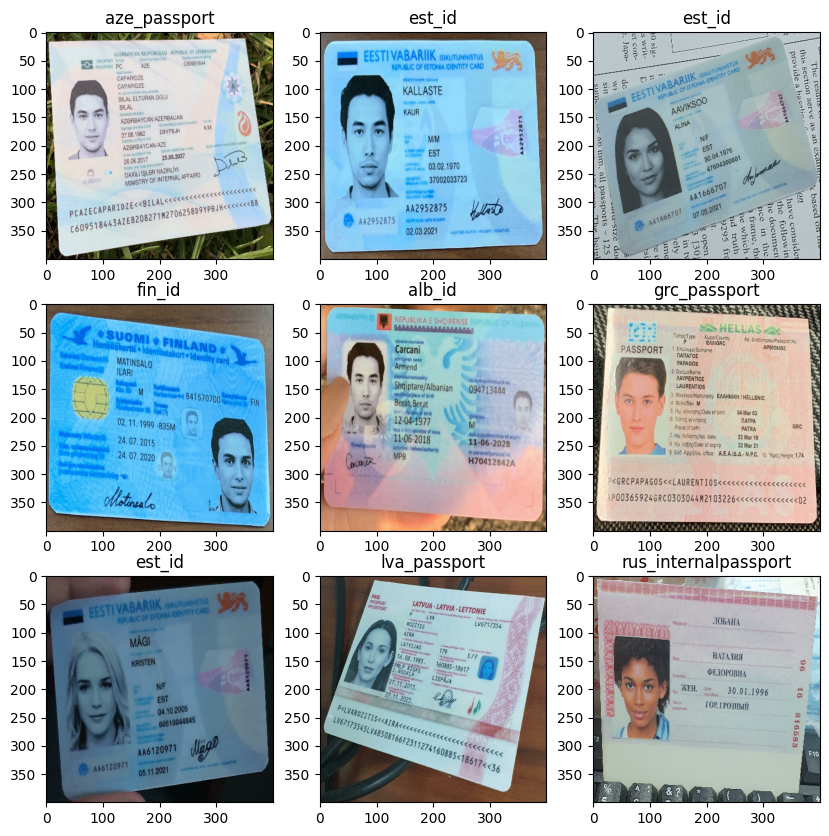

In [5]:
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(labels[label[i]])

# Preprocessing and Augmentation

In [6]:
preprocess = tf.keras.Sequential([
    # resize
    layers.Resizing(img_height, img_width),
    # rescale
    layers.Rescaling(1./255)
])

In [7]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.1),
    layers.RandomBrightness(factor=0.2),
    layers.GaussianNoise(stddev=0.1),
])

2024-10-08 17:29:28.967422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


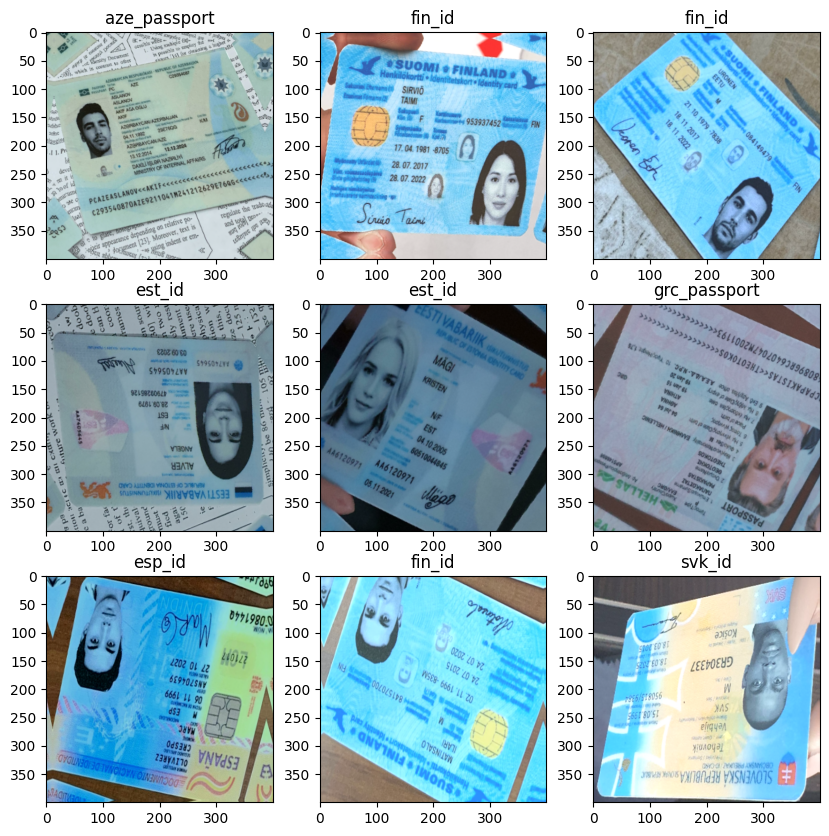

In [8]:
plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_image = augmentation(image)
        plt.imshow(aug_image[i].numpy().astype("uint8"))
        plt.title(labels[label[i]])

# Model

In [13]:
model = Sequential([
    augmentation,
    preprocess,
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_labels)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 400, 400, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (32, 400, 400, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 400, 400, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 200, 200, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 200, 200, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 100, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 100, 100, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 50, 50, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 40000)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (32, 40000)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 128)              │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,146,298 (19.63 MB)

 Trainable params: 5,146,298 (19.63 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.0968 - loss: 2.3541 - val_accuracy: 0.1800 - val_loss: 2.1228
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2500 - loss: 2.0387 - val_accuracy: 0.4267 - val_loss: 1.7874
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3931 - loss: 1.7552 - val_accuracy: 0.5600 - val_loss: 1.3038
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5053 - loss: 1.3845 - val_accuracy: 0.7600 - val_loss: 1.0790
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6189 - loss: 1.2412 - val_accuracy: 0.7533 - val_loss: 0.9379
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6469 - loss: 1.0238 - val_accuracy: 0.7333 - val_loss: 0.7842
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7157 - loss: 0.9495 - val_accuracy: 0.8600 - val_loss: 0.7511
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7407 - loss: 0.8794 - val_accuracy: 0.8733 - v

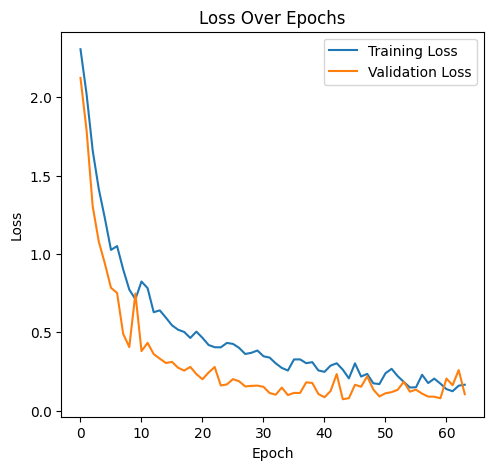

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

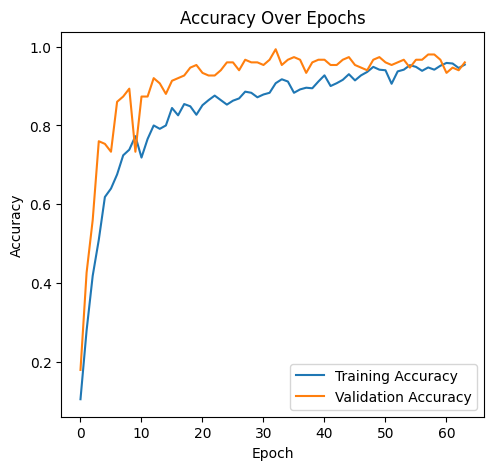

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(test_ds)
y_pred_label = np.argmax(y_pred_prob, axis=1)

y_true_label = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

print(classification_report(y_true_label, y_pred_label))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       0.93      0.87      0.90        15
           4       0.94      1.00      0.97        15
           5       1.00      0.93      0.97        15
           6       1.00      1.00      1.00        15
           7       0.94      1.00      0.97        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



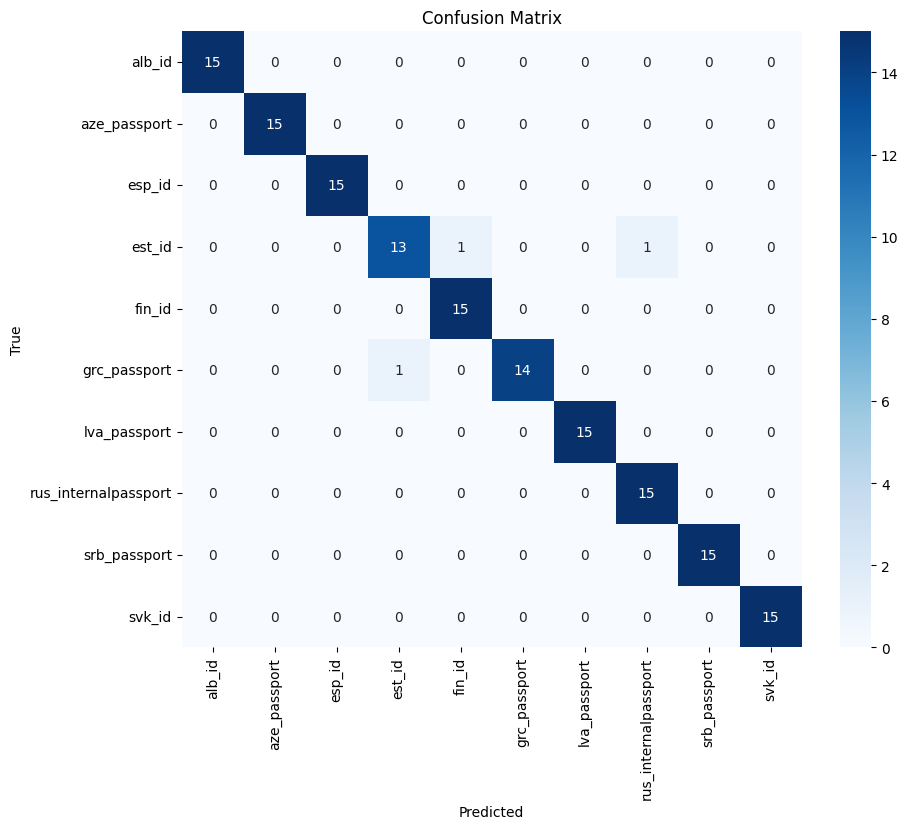

In [18]:
plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_true_label, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Export

In [20]:
model.save('../app/model/cnn.keras')